# Exoplanet Exploration through Data Mining
### Author: Josh Stanton

 Date: February 09, 2025


The NASA Exoplanet Archive file consists of 38,090 entries across 92 columns covering the planets'
mass relative to Earth and Jupiter, Insolation Flux, the Orbital Periods, among other properties.
In total, 38,090 rows by 92 columns results in just over 3.5 million points of data, which need to
be cleaned and tailored to answer the questions:

• Are there any patterns in exoplanet discovery over time?

• Do certain facilities have a propensity for discovering certain exoplanet types more than others?

• Is there a relationship between planet size and stellar gravity?

• Does the number of stars relative to an exoplanet have any effect on its orbital?

• Have specific discovery methods been more successful than others, or has a specific discovery method identified more planets than others?




In [2]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier


exoplanets = pd.read_csv('NASA Exoplanet Archive.csv')


In [3]:
exoplanets.columns

Index(['Planet Name', 'Host Name', 'Default Parameter Set', 'Number of Stars',
       'Number of Planets', 'Discovery Method', 'Discovery Year',
       'Discovery Facility', 'Solution Type', 'Controversial Flag',
       'Planetary Parameter Reference', 'Orbital Period [days]',
       'Orbital Period Upper Unc. [days]', 'Orbital Period Lower Unc. [days]',
       'Orbital Period Limit Flag', 'Orbit Semi-Major Axis [au]',
       'Orbit Semi-Major Axis Upper Unc. [au]',
       'Orbit Semi-Major Axis Lower Unc. [au]',
       'Orbit Semi-Major Axis Limit Flag', 'Planet Radius [Earth Radius]',
       'Planet Radius Upper Unc. [Earth Radius]',
       'Planet Radius Lower Unc. [Earth Radius]', 'Planet Radius Limit Flag',
       'Planet Radius [Jupiter Radius]',
       'Planet Radius Upper Unc. [Jupiter Radius]',
       'Planet Radius Lower Unc. [Jupiter Radius]',
       'Planet Radius Limit Flag.1', 'Planet Mass or Mass*sin(i) [Earth Mass]',
       'Planet Mass or Mass*sin(i) [Earth Mass] Upper

Unc. is shorthand for "uncertainty" 

In [4]:
exoplanets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38090 entries, 0 to 38089
Data columns (total 92 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Planet Name                                           38090 non-null  object 
 1   Host Name                                             38090 non-null  object 
 2   Default Parameter Set                                 38090 non-null  int64  
 3   Number of Stars                                       38090 non-null  int64  
 4   Number of Planets                                     38090 non-null  int64  
 5   Discovery Method                                      38090 non-null  object 
 6   Discovery Year                                        38090 non-null  int64  
 7   Discovery Facility                                    38090 non-null  object 
 8   Solution Type                                         38

In [14]:
discovery = exoplanets[['Planet Name', 'Host Name', 'Discovery Method', 'Discovery Year',
       'Discovery Facility', 'Solution Type']]
discovery.describe

<bound method NDFrame.describe of                 Planet Name           Host Name Discovery Method  \
0      11 Comae Berenices b  11 Comae Berenices  Radial Velocity   
1      11 Comae Berenices b  11 Comae Berenices  Radial Velocity   
2      11 Comae Berenices b  11 Comae Berenices  Radial Velocity   
3        11 Ursae Minoris b    11 Ursae Minoris  Radial Velocity   
4        11 Ursae Minoris b    11 Ursae Minoris  Radial Velocity   
...                     ...                 ...              ...   
38085      ups Andromedae d      ups Andromedae  Radial Velocity   
38086          ups Leonis b          ups Leonis  Radial Velocity   
38087          xi Aquilae b          xi Aquilae  Radial Velocity   
38088          xi Aquilae b          xi Aquilae  Radial Velocity   
38089          xi Aquilae b          xi Aquilae  Radial Velocity   

       Discovery Year                      Discovery Facility  \
0                2007                        Xinglong Station   
1                20

In [20]:
count = discovery.groupby('Discovery Year').size()

In [18]:
discovery['Discovery Method'].unique()

array(['Radial Velocity', 'Imaging', 'Eclipse Timing Variations',
       'Transit', 'Transit Timing Variations', 'Astrometry',
       'Microlensing', 'Disk Kinematics', 'Orbital Brightness Modulation',
       'Pulsation Timing Variations', 'Pulsar Timing'], dtype=object)

In [22]:
exoplanets.groupby('Discovery Method').size().sort_values(ascending=False)

Discovery Method
Transit                          34445
Radial Velocity                   2584
Microlensing                       697
Transit Timing Variations          152
Imaging                            148
Eclipse Timing Variations           24
Orbital Brightness Modulation       21
Pulsar Timing                       13
Astrometry                           3
Pulsation Timing Variations          2
Disk Kinematics                      1
dtype: int64

<Axes: >

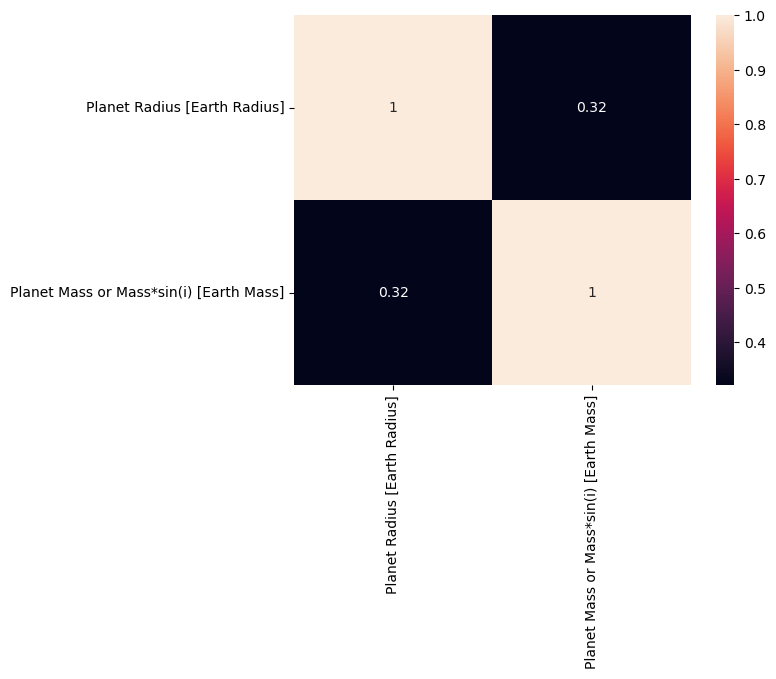

In [24]:
exoplanet_gravity = exoplanets[['Planet Name', 'Host Name','Planet Radius [Earth Radius]','Planet Mass or Mass*sin(i) [Earth Mass]']]

sns.heatmap(exoplanet_gravity.corr(method='pearson', numeric_only=True),annot=True)

In [26]:
exoplanet_sizes = exoplanets[['Planet Name', 'Host Name', 'Orbital Period [days]', 'Planet Radius [Earth Radius]',
                              'Orbit Semi-Major Axis [au]','Planet Radius [Jupiter Radius]','Planet Mass or Mass*sin(i) [Earth Mass]']]

exoplanet_sizes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38090 entries, 0 to 38089
Data columns (total 7 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Planet Name                              38090 non-null  object 
 1   Host Name                                38090 non-null  object 
 2   Orbital Period [days]                    34904 non-null  float64
 3   Planet Radius [Earth Radius]             26414 non-null  float64
 4   Orbit Semi-Major Axis [au]               21538 non-null  float64
 5   Planet Radius [Jupiter Radius]           26414 non-null  float64
 6   Planet Mass or Mass*sin(i) [Earth Mass]  6331 non-null   float64
dtypes: float64(5), object(2)
memory usage: 2.0+ MB


<Axes: >

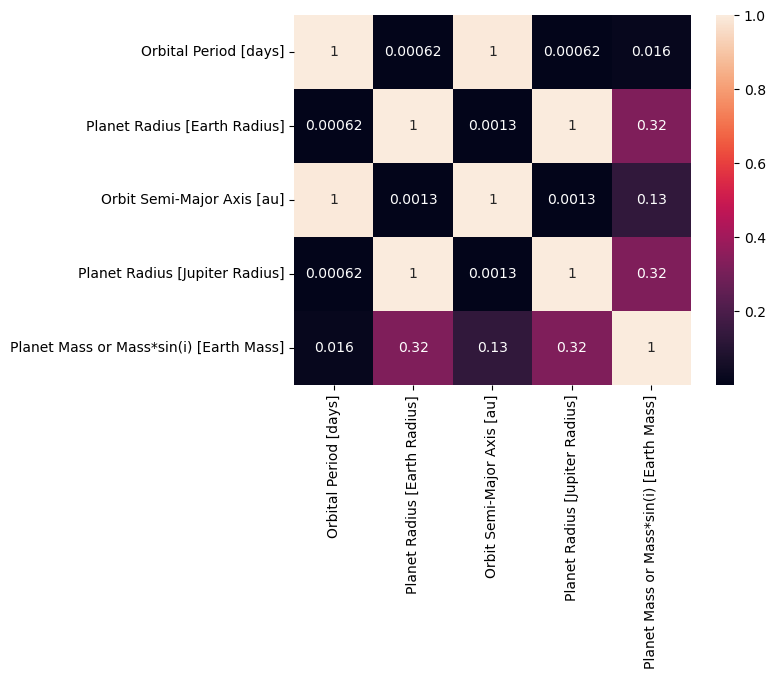

In [28]:
sns.heatmap(exoplanet_sizes.corr(method='pearson', numeric_only=True),annot=True)

In [30]:
exoplanets['Discovery Facility'].nunique()

71

In [32]:
exoplanets['Discovery Facility'].unique()

array(['Xinglong Station', 'Thueringer Landessternwarte Tautenburg',
       'Okayama Astrophysical Observatory', 'W. M. Keck Observatory',
       'Multiple Observatories', 'Lick Observatory', 'Gemini Observatory',
       'Subaru Telescope', 'Paranal Observatory',
       'Cerro Tololo Inter-American Observatory', 'Mauna Kea Observatory',
       'European Space Agency (ESA) Gaia Satellite',
       'Hubble Space Telescope', 'Kepler', 'Haute-Provence Observatory',
       'McDonald Observatory', 'Anglo-Australian Telescope',
       'Bohyunsan Optical Astronomical Observatory',
       'Transiting Exoplanet Survey Satellite (TESS)',
       'Roque de los Muchachos Observatory', 'K2',
       'Wide-field Infrared Survey Explorer (WISE) Sat',
       'La Silla Observatory', 'Calar Alto Observatory',
       'NASA Infrared Telescope Facility (IRTF)', 'CoRoT',
       'Multiple Facilities', 'Yunnan Astronomical Observatory',
       'Spitzer Space Telescope', 'MEarth Project',
       'Very Long Baselin

In [34]:
count = exoplanets.groupby('Discovery Facility').size()
count = count.sort_values(ascending=False)

for i in count:
    print(i)

28217
2017
1581
964
648
608
569
563
358
311
284
165
159
153
131
122
99
87
83
73
68
66
65
62
59
52
43
41
40
39
34
33
32
26
26
25
22
18
18
14
12
11
8
8
7
6
6
6
6
5
4
4
4
4
3
2
2
2
2
2
1
1
1
1
1
1
1
1
1
1
1


#  There is **a lot** of data, let's start with one question at a time.
### First, is there a relationship between planet size and stellar gravity?


<Axes: >

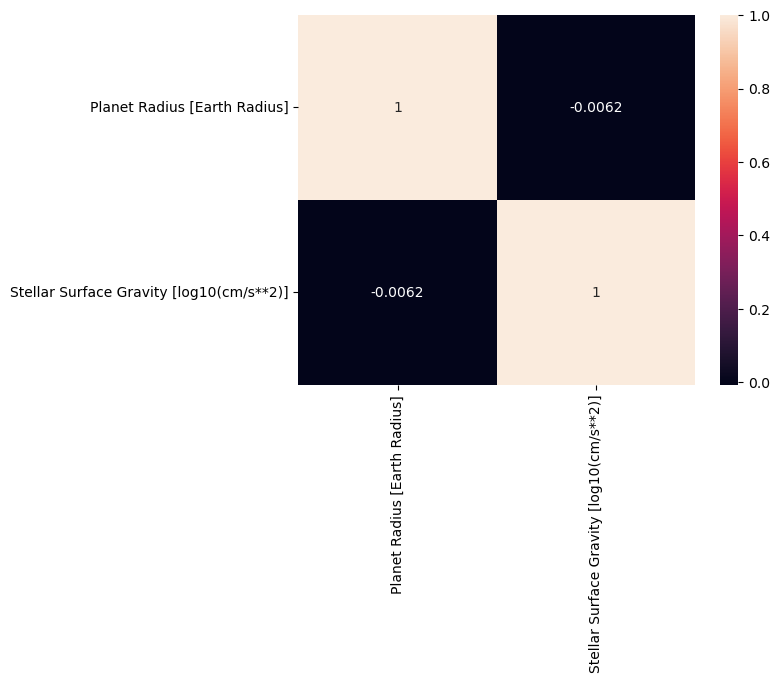

In [44]:
gravity_size = exoplanets[['Planet Name','Planet Radius [Earth Radius]', 'Stellar Surface Gravity [log10(cm/s**2)]']]

sns.heatmap(gravity_size.corr(method='pearson', numeric_only=True),annot=True)

From a quick glance, there is very little correlation between the planet size and stellar gravity, so let's have a look at planet side and its orbital period. 

<Axes: >

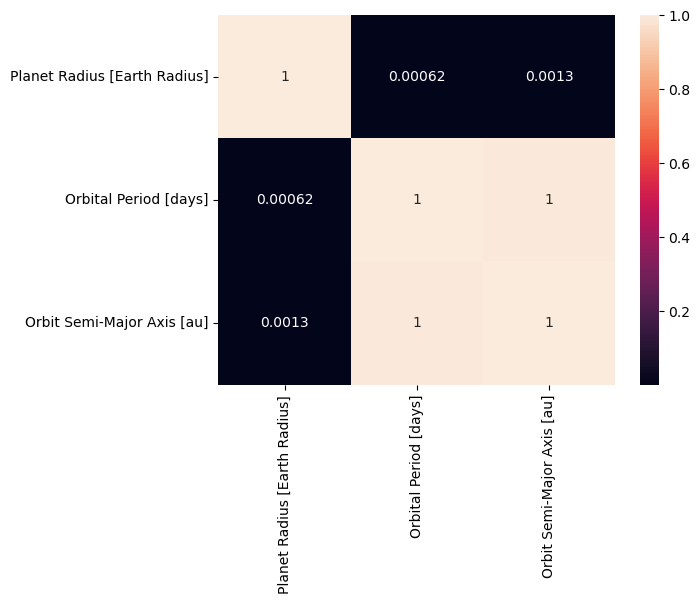

In [50]:
orbital_size = exoplanets[['Planet Name','Planet Radius [Earth Radius]', 'Orbital Period [days]', 'Orbit Semi-Major Axis [au]']]

sns.heatmap(orbital_size.corr(method='pearson', numeric_only=True),annot=True)

In [62]:
orbital_size.describe()

,Planet Radius [Earth Radius],Orbital Period [days],Orbit Semi-Major Axis [au]
count,26414.000000,3.490400e+04,21538.000000
mean,5.425483,1.251155e+04,4.675064
std,72.705251,2.152983e+06,182.569889
min,0.270000,9.070629e-02,0.004400
25%,1.550000,4.409359e+00,0.054600
50%,2.290000,1.035532e+01,0.100500
75%,3.220000,2.665658e+01,0.215875
max,4282.980000,4.020000e+08,19000.000000
